# Activity 7

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

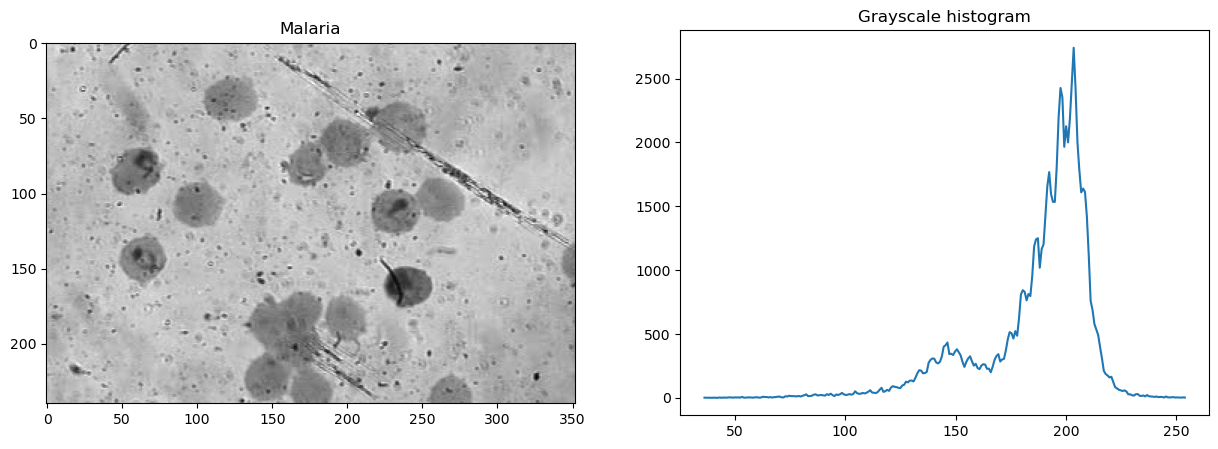

In [17]:
def mean_gray(img):
    grayscale = np.dot(img[...,:3],[0.2989, 0.5870, 0.1140])
    return grayscale

malaria = plt.imread('malaria(1).jpeg')

malaria_gray = mean_gray(malaria)

count, bins = np.histogram(malaria_gray.flatten(),256)

plt.figure(figsize=(15,5))
    
plt.subplot(121)
plt.imshow(malaria_gray,cmap='gray')
plt.title('Malaria')

plt.subplot(122)
plt.plot(bins[:-1],count)
plt.title('Grayscale histogram')
plt.show()

In [18]:
from skimage.measure import label, regionprops, regionprops_table
from skimage.io import imshow

cells = np.logical_and(malaria_gray < 149.50, malaria_gray > 90)
# cells = malaria_gray < 164

cells = cells.astype('uint8')

SE_circ = np.array([[0,0,1,1,1,0,0],
                    [0,1,1,1,1,1,0],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [0,1,1,1,1,1,0],
                    [0,0,1,1,1,0,0]])
SE_circ = SE_circ.astype('uint8')

malaria_closed = cv2.morphologyEx(cells,cv2.MORPH_CLOSE,SE_circ)
malaria_morphed = cv2.morphologyEx(malaria_closed,cv2.MORPH_OPEN,SE_circ)

# plt.imsave('malaria morphed.png',malaria_morphed,cmap='gray')

In [19]:
def label_img_color(img_binary):
    
    img_labeled = label(img_binary)

    plt.imshow(img_labeled, cmap='plasma')
    plt.title('Color labeled image')
    
    return img_labeled

def label_img_num(img_binary, img):
    
    img_labeled = label(img_binary)
    img_regionprops = regionprops(img_labeled)

    plt.imshow(img)
    plt.title('Number labeled image')
    
    for prop in img_regionprops:
        y, x = prop.centroid
        plt.text(x,y, prop.label,color='r')

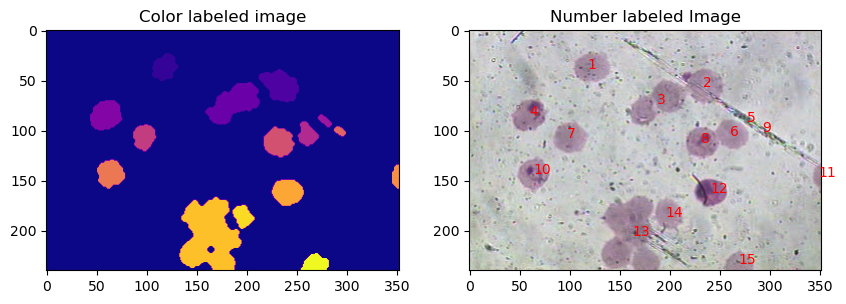

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(121)
malaria_labeled = label_img_color(malaria_morphed)

plt.subplot(122)
malaria_regionprops = regionprops(malaria_labeled)
plt.imshow(malaria, cmap='plasma')
plt.title('Number labeled Image')

for prop in malaria_regionprops:
    y, x = prop.centroid
    plt.text(x,y, prop.label,color='r')
    
# plt.savefig('malaria labeled.png')
plt.show()

In [21]:
def features_img(img_labeled):
    properties = ['area','convex_area','bbox_area','major_axis_length', 'minor_axis_length','eccentricity']
    img_props_df = pd.DataFrame(regionprops_table(img_labeled, properties=properties))
    img_props_df = img_props_df.reset_index(drop=True)
    img_props_df.index += 1
    

    return img_props_df

# properties = ['area','convex_area','bbox_area','major_axis_length', 'minor_axis_length','eccentricity']
# malaria_props_df = pd.DataFrame(regionprops_table(malaria_labeled, properties=properties))
# malaria_props_df = malaria_props_df.reset_index(drop=True)
# malaria_props_df.index += 1

# malaria_props_df

features_img(malaria_labeled)

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity
1,508,551,728,28.665532,22.922793,0.600448
2,874,958,1320,41.005534,28.087826,0.728565
3,1301,1475,2268,60.044176,29.215674,0.873642
4,742,770,960,33.758593,28.155161,0.551742
5,98,101,182,17.229406,7.348337,0.904488
6,334,361,525,24.461777,18.562709,0.651271
7,454,476,621,26.511210,22.079777,0.553504
8,695,728,961,30.800515,28.910757,0.344884
9,79,82,120,13.180091,7.666895,0.813401
10,586,619,812,27.618415,27.401151,0.125186


In [22]:
def parametric(img, ROI, thresh):
    
    def img_norm(img):     # normalize an image
        img = img/255      # to avoid int limit error
        R = img[:,:,0]
        G = img[:,:,1]
        B = img[:,:,2]
        I = R+G+B
        I = np.where(I==0, 10e10, I)  # to avoid dividing by zero (which gives a large number, so set it to a large number already)
        R_norm = R/I
        G_norm = G/I
        B_norm = B/I
        img_norm = np.dstack([R_norm,G_norm,B_norm])
        return img_norm
    
    def gaussian_PDF(img, ROI):
        # normalize
        img_normed = img_norm(img)
        ROI_normed = img_norm(ROI)

        # normalized image values
        r = img_normed[:,:,0]
        g = img_normed[:,:,1]

        # ROI values
        ROI_r = ROI_normed[:,:,0]
        ROI_g = ROI_normed[:,:,1]

        # parameters from ROI values
        mu_r = np.mean(ROI_r)
        mu_g = np.mean(ROI_g)
        sigma_r = np.std(ROI_r)
        sigma_g = np.std(ROI_g)

        # individual probabality of normalized image to be in red and green space of ROI
        gauss_r = 1/(sigma_r*np.sqrt(2*np.pi))*np.exp(-(r-mu_r)**2/(2*sigma_r**2))
        gauss_g = 1/(sigma_g*np.sqrt(2*np.pi))*np.exp(-(g-mu_g)**2/(2*sigma_g**2))

        # joint probability
        return gauss_r*gauss_g

    img_gauss = gaussian_PDF(img, ROI) # get probability of image in ROI

    img_mask = img_gauss > thresh   # threshold
    r_img = img[:,:,0]*img_mask
    g_img = img[:,:,1]*img_mask
    b_img = img[:,:,2]*img_mask
    img_segmented = np.dstack((r_img,g_img,b_img))
    
    img_segmented = np.where(img_segmented != 0,1,0)
    
    img_binary = np.logical_or(img_segmented[...,0],img_segmented[...,0],img_segmented[...,0])

#     plt.imshow(img_segmented)
    
    return img_binary

def morph_dilate(img_binary,SE,anchor=(-1,-1)):
    return cv2.dilate(img_binary,SE,anchor=anchor)

def morph_erode(img_binary,SE,anchor=(-1,-1)):
    return cv2.erode(img_binary,SE,anchor=anchor)

def morph_open(img_binary,SE):
    return cv2.morphologyEx(img_binary,cv2.MORPH_OPEN,SE)

def morph_close(img_binary,SE):
    return cv2.morphologyEx(img_binary,cv2.MORPH_CLOSE,SE)

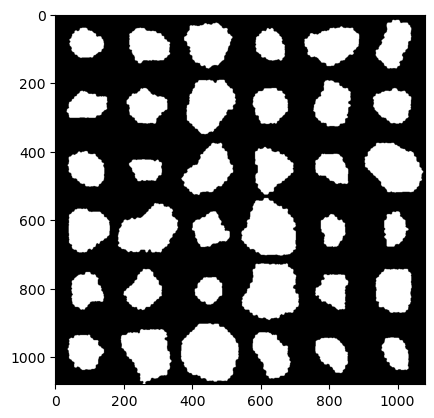

In [23]:
sand = plt.imread('sand.jpg')

sand_ROI = sand[400:500,960:1000,:]

sand_segmented = parametric(sand,sand_ROI,10e-10)
sand_segmented = sand_segmented.astype('uint8')

SE_circ = np.array([[0,0,1,1,1,0,0],
                    [0,1,1,1,1,1,0],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [0,1,1,1,1,1,0],
                    [0,0,1,1,1,0,0]])
SE_circ = SE_circ.astype('uint8')

sand_closed = cv2.morphologyEx(sand_segmented,cv2.MORPH_CLOSE,SE_circ)
sand_morphed = cv2.morphologyEx(sand_closed,cv2.MORPH_OPEN,SE_circ)

# plt.imsave('sand morphed.png',sand_morphed,cmap='gray')
plt.imshow(sand_morphed,cmap='gray')

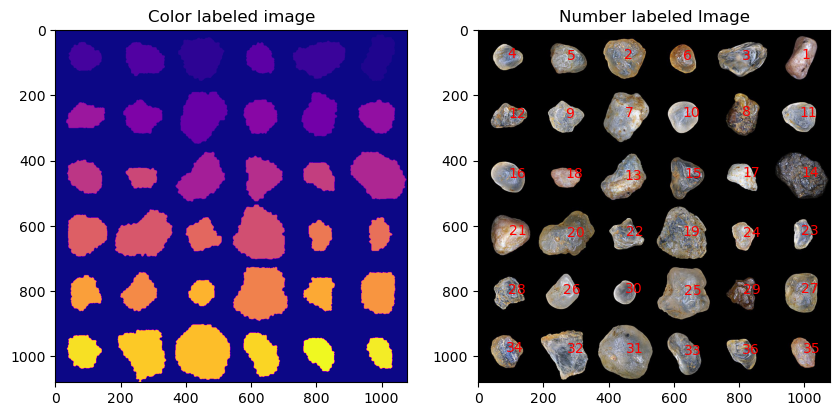

In [24]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sand_labeled = label_img_color(sand_morphed)

plt.subplot(122)
plt.imshow(sand)
plt.title('Number labeled Image')
malaria_regionprops = regionprops(sand_labeled)
for prop in malaria_regionprops:
    y, x = prop.centroid
    plt.text(x,y, prop.label,color='r')
    
# plt.savefig('sand labeled.png')
plt.show()

In [25]:
features_img(sand_labeled)

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity
1,9586,10610,14768,150.854494,83.519476,0.832754
2,12929,13964,18894,130.874833,128.557389,0.187353
3,12699,13746,18560,160.042932,103.721779,0.761566
4,6405,6783,8888,99.042180,83.443520,0.538689
5,9186,9852,12376,125.933301,95.118094,0.655373
6,6108,6460,8170,98.302815,80.261917,0.577379
7,16181,17102,22896,165.734322,127.043549,0.642185
8,10545,11434,14715,133.786110,102.674592,0.641105
9,8425,9238,12376,113.796896,97.213630,0.519824
10,8279,8716,10815,105.391019,101.016830,0.285107


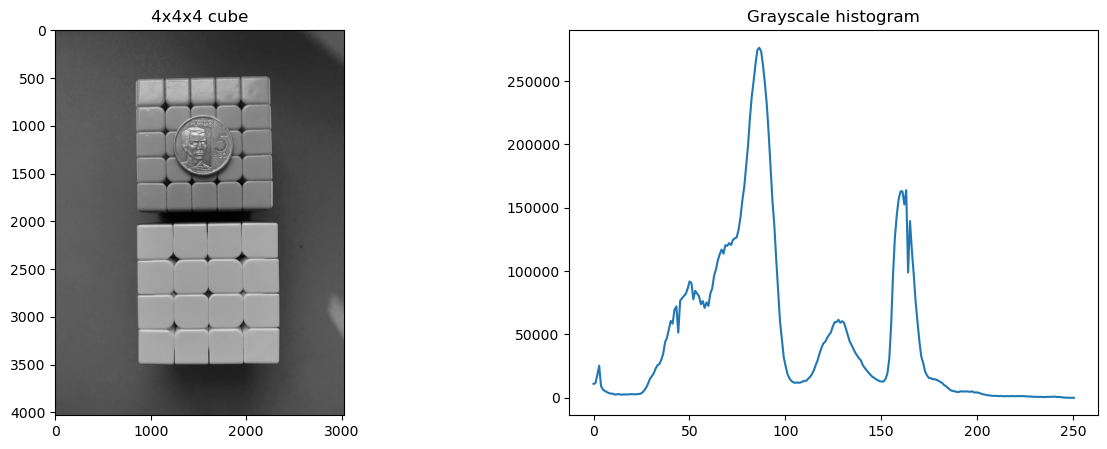

In [27]:
cube = plt.imread('cube.jpg')

cube_gray = mean_gray(cube)

count, bins = np.histogram(cube_gray.flatten(),256)

plt.figure(figsize=(15,5))
    
plt.subplot(121)
plt.imshow(cube_gray,cmap='gray')
plt.title('4x4x4 cube')

plt.subplot(122)
plt.plot(bins[:-1],count)
plt.title('Grayscale histogram')

# plt.savefig('cube histogram.png')
plt.show()

In [28]:
def subplots2(img1,img2,title1='Original image',title2='Structuring element'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.imshow(img1,cmap='gray')
    plt.title(title1)
    
    plt.subplot(122)
    plt.imshow(img2,cmap='gray')
    plt.title(title2)

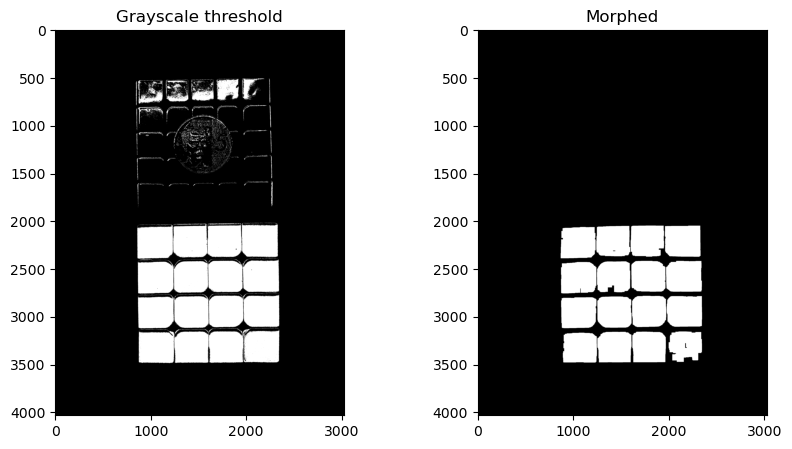

In [29]:
cube_thresh = np.logical_and(cube_gray > 150,cube_gray < 175)
# cells = malaria_gray < 164

cube_thresh = cube_thresh.astype('uint8')
SE_sq = np.ones([51,51])
SE_sq2 = np.ones([5,5])

cube_morphed = morph_close(morph_close(morph_open(cube_thresh,SE_sq),SE_sq2),SE_sq2)
subplots2(cube_thresh,cube_morphed,title1='Grayscale threshold',title2='Morphed')
# plt.savefig('cube morphed.png')
plt.show()

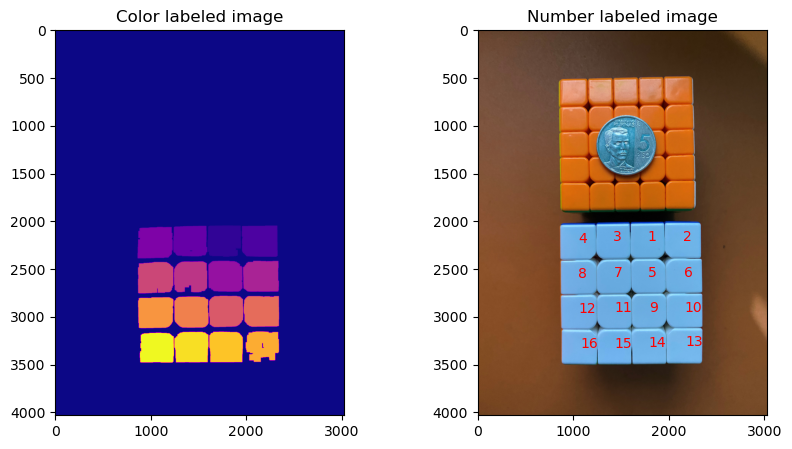

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(121)
cube_labeled_col = label_img_color(cube_morphed)
plt.subplot(122)
cube_labeled_num = label_img_num(cube_morphed,cube)
# plt.savefig('cube labeled.png')
plt.show()

In [32]:
features_img(cube_labeled_col)

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity
1,106819,109602,114100,389.948556,360.472190,0.381401
2,117630,118642,121598,423.651797,368.142999,0.494855
3,106330,108354,112890,393.669876,356.670306,0.423248
4,112917,114834,120048,411.624004,361.887179,0.476510
5,108558,109715,115311,399.364158,353.727160,0.464209
6,115163,117061,121125,418.100504,363.093487,0.495801
7,102265,107226,112752,392.262729,349.625250,0.453407
8,114053,115953,121730,416.743115,359.556599,0.505584
9,109650,110797,116739,396.968677,359.645148,0.423323
10,113503,114881,118770,414.551258,360.484931,0.493794
